In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from torchvision.transforms import ToTensor
from torchvision import transforms
import glob
import torch.nn.functional as F
import torch.nn as nn
from matplotlib import cm
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from IPython.display import clear_output
import math
import time
import sys

In [2]:
def extractLabels(file, color = np.array([None]), quantile = sys.float_info.max):
    
    if color.all() != None:
        return [np.mean(color)]
    
    backup = file
    if 'nan' in file:
        #print(backup)
        return None
    file = file.split("\\")[1]
    file = file.split("_", 16)
    file[16] = file[16].split('.', 1)[0]
    #remove useless labels
    del file[16] #'Random string'
    del file[15] #'Body Style'
    del file[14] #'Passenger Doors',
    del file[13] #'Passenger Capacity'
    del file[12] #'Drivetrain'
    del file[11] #'Gas Mileage'
    del file[10] #'Length, Overall (in)'
    del file[9] #'Height, Overall (in)'
    del file[8] #'Width, Max w/o mirrors (in)'
    del file[7] #'Engine Type'
    del file[6] #'Displacement'
    #del file[5] #'SAE Net Horsepower @ RPM'
    del file[4] #'Front Wheel Size (in)'
    del file[3] #'MSRP' Prix
    del file[2] #'Year'
    del file[1] #'Model'
    del file[0]#Make'
    
    try:
        file = [int(float(i)) for i in file]
    except Exception as e: #get name of file who raises an error
        print(backup)
        return None
    if(file[0] <= quantile):
        return file
    else:
        return None

In [3]:
def Normalize_labels(labels):
    for i in range(labels.shape[1]):
        minimum = labels[:,i].min()
        maximum = labels[:,i].max()
        print(minimum, maximum)
        for j in range(labels.shape[0]):
            labels[j,i] = (labels[j,i] - minimum)/(maximum - minimum)
    return labels  

In [4]:
num = 3000
tensorLab_list = []
None_id = []
i = 0

PATH = 'Data/colorsv3.npy'
colors = np.load(PATH)

q95_RPM = 460


for filename in glob.glob('Data/No_background/*.jpg'):
    labels = extractLabels(filename, color = colors[i]) #to extract colors
    #labels = extractLabels(filename, quantile = q95_RPM)
    if labels != None:
        tensorLab_list.append(torch.FloatTensor(labels))
    else: None_id.append(i)
    i += 1
    #if i >= num: break
    
LabelsTens = torch.stack(tensorLab_list)
LabelsTens = Normalize_labels(LabelsTens)

tensor(0.0249) tensor(0.9539)


In [5]:
num = 3000
image_size = 32
total_files = 19921
current_perc = 0

tensorIm_list = []
i = 0


for filename in glob.glob('Data/No_background/*.jpg'):
    
    image=np.array(Image.open(filename))
    
    lengths = image.shape
    gap = np.abs(lengths[0] - lengths[1])
    argm = np.argmax(lengths)
    if argm == 0:
        pads = [int(gap/2),0,int(gap/2),0]
    else:
        pads = [0,int(gap/2),0,int(gap/2)]
    
    
    transform=T.Compose([
        T.ToPILImage(),
        T.Pad(pads, fill = 255),
        T.Resize(image_size),
        T.ToTensor()])
    
    image = transform(image)
    if(i not in None_id): tensorIm_list.append(image)
    if math.floor(i/total_files*100) > current_perc:
        current_perc += 1
        s = '[' + '-'*current_perc + str(current_perc+1) + '%' + ' '*(99-current_perc)+ ']'
        print('       ----------------------------------------Loading Data----------------------------------------', '\n', s)
        clear_output(wait=True)
        
        
    i += 1
    #if i >= num: break
CarsTens = torch.stack(tensorIm_list)

       ----------------------------------------Loading Data---------------------------------------- 
 [---------------------------------------------------------------------------------------------------100%]


In [6]:
print(CarsTens.shape)

torch.Size([19921, 3, 32, 32])


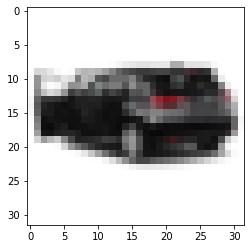

In [7]:
plt.imshow(CarsTens[161].permute(1,2,0))

In [8]:
class Train_Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self):
        'Initialization'

    def __len__(self):
        'Denotes the total number of samples'
        #return len(self.list_IDs)
        return LabelsTens.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = CarsTens[index]
        y = LabelsTens[index]

        return X, y

In [9]:
batch_size = 32

dl = Train_Dataset()
train_loader = torch.utils.data.DataLoader(dl, batch_size=batch_size,shuffle=True)
test = next(iter(train_loader))
print(f"X_component: {test[0].shape} \nY-component: {test[1].shape}")

X_component: torch.Size([32, 3, 32, 32]) 
Y-component: torch.Size([32, 1])


In [10]:
def DiffAugment(x, label, policy='color,translation,cutout,flip', channels_first = True, color = False):
    initlab = label
    if not channels_first:
        x = x.permute(0, 3, 1, 2)
    for p in policy.split(','):
        for f in AUGMENT_FNS[p]:
            x, label = f(x, label)
    if not channels_first:
        x = x.permute(0, 2, 3, 1)
    x = x.contiguous()
    
    return x, (label if color else initlab)

In [11]:
def rand_brightness(x, label):
    factor = (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)*0.5 - 0.25)
    change = torch.unsqueeze(factor.reshape(x.size(0)), dim = -1)
    #x = x + factor.repeat(1,3,x.shape[2],x.shape[3])*(torch.mean(x, dim = 1, keepdim = True) != 1.)
    x = x + factor.repeat(1,3,x.shape[2],x.shape[3])
    return x, (label + change)

In [12]:
def rand_saturation(x, label):
    x_mean = x.mean(dim=1, keepdim=True)
    factor = (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)*2)
    change = torch.unsqueeze(factor.reshape(x.size(0)), dim = -1)
    x = (x - x_mean) * factor + x_mean
    return x, label*change

In [13]:
def rand_translation(x, label, ratio=0.05):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0], value = 1.)
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2).contiguous()
    return x, label

In [14]:
def rand_cutout(x, label, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x, label

In [15]:
def rand_flip(x, label, proba = 0.5):
    flips = torch.rand(x.size(0),1,1,1, dtype=x.dtype, device=x.device).repeat(1,3,x.shape[2], x.shape[3])
    x = x*(flips <= proba) + torch.flip(x, dims = [3])*(flips > proba)
    
    return x, label

In [16]:
AUGMENT_FNS = {
    'color': [rand_brightness],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
    'flip': [rand_flip],
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


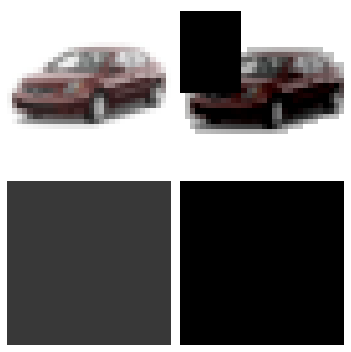

In [29]:
axes=[]
fig=plt.figure(figsize = (5,5))

pic = []

data = next(iter(train_loader))
imgs = data[0]
labels = data[1]

aug, aug_labels = DiffAugment(imgs, labels, color = True)

pic.append(imgs[0].permute(1,2,0))
pic.append(aug[0].permute(1,2,0))
pic.append(labels[0].reshape(1,1))
pic.append(aug_labels[0].reshape(1,1))

for i in range(4):    
    b = pic[i]
    axes.append(fig.add_subplot(2,2,i+1))
    if i < 2:
        plt.imshow(b)
    else:
        plt.imshow(b, cmap="gray", vmin=0, vmax=1)
    plt.axis('off')





fig.tight_layout()    
plt.show()